## Credit Card Fraud/Anomaly Detection (DecisionTrees, XGBoost, CNNs, and ANNs)

##### About the Data:

The datasets contains transactions made by credit cards in September 2013 by european cardholders.
This dataset presents transactions that occurred in two days, where we have 492 frauds out of 284,807 transactions. The dataset is highly unbalanced, the positive class (frauds) account for 0.172% of all transactions.

It contains only numerical input variables which are the result of a PCA transformation. Unfortunately, due to confidentiality issues, we cannot provide the original features and more background information about the data. Features V1, V2, … V28 are the principal components obtained with PCA, the only features which have not been transformed with PCA are 'Time' and 'Amount'. Feature 'Time' contains the seconds elapsed between each transaction and the first transaction in the dataset. The feature 'Amount' is the transaction Amount, this feature can be used for example-dependant cost-senstive learning. Feature 'Class' is the response variable and it takes value 1 in case of fraud and 0 otherwise.

##### Objective:

To develop a classification model that can identify, with high certainty, whether a transaction is fradulent or not given the current dataset.

### 1. Import Libraries:

In [1]:
import pandas as pd
import numpy as np
import psycopg2
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")

### 2. Import Data:

In [2]:
# Establish the connection
conn = psycopg2.connect(
    host="localhost",
    database="credit_card",
    user="postgres",
    password=1978
)

# Create a cursor object
cursor = conn.cursor()

# Execute a SQL query
cursor.execute("SELECT * FROM credit_card")

# Fetch all the rows from the query result
rows = cursor.fetchall()

# Get the column names
columns = [desc[0] for desc in cursor.description]

# Create a pandas DataFrame from the rows and columns
df = pd.DataFrame(rows, columns=columns)

df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,36015,1.111629,-1.352318,0.333303,-2.174766,-1.252337,0.147722,-0.910104,0.240456,0.498590,...,-0.232407,-0.134282,-0.020138,-0.283100,0.225278,-0.044462,0.066723,0.019442,90.31,0
1,36015,1.441729,-0.520490,-0.137657,-0.623433,-0.673305,-0.830835,-0.313431,-0.231444,-0.627544,...,0.115976,0.341796,-0.226763,-0.079928,0.829958,-0.032829,-0.015831,-0.000944,20.00,0
2,36015,-18.367488,-11.675048,-7.339436,6.182679,-1.029605,-2.425726,-2.683085,-0.921402,0.171887,...,-3.771041,0.834364,-1.288291,1.258129,-0.461819,-0.035442,4.564467,-8.310167,1.00,0
3,36015,1.070004,0.438997,0.495253,2.350349,0.103369,0.177895,0.068300,0.128966,-1.031827,...,0.099362,0.198456,-0.057871,0.004240,0.448279,0.047552,-0.010484,0.009087,26.78,0
4,36015,-1.809316,0.383999,1.194751,1.026893,-0.306249,-0.389872,-0.239173,0.303371,-0.006770,...,-0.135197,-0.270760,-0.435093,0.496442,-0.735687,0.212580,-0.251139,-0.184671,40.95,0


### 3. Exploratory Data Analysis:

In [3]:
df.shape

(284807, 31)

In [4]:
df.columns

Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
       'Class'],
      dtype='object')

In [5]:
df.describe()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,1.161589e-15,3.376991e-16,-1.456178e-15,2.098045e-15,1.018686e-15,1.498490e-15,-5.760045e-16,1.185539e-16,-2.413391e-15,2.235161e-15,...,1.615896e-16,-3.392958e-16,2.632536e-16,4.473365e-15,5.117379e-16,1.684105e-15,-3.656910e-16,-1.219219e-16,88.349619,0.001727
std,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,1.088850e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,-2.458826e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,-5.354257e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,-9.291738e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,4.539234e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,2.374514e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  object 
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

In [7]:
df.isnull().sum()

Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64

In [8]:
df.Class.value_counts()
# 0 = Valid
# 1 = Fraud

Class
0    284315
1       492
Name: count, dtype: int64

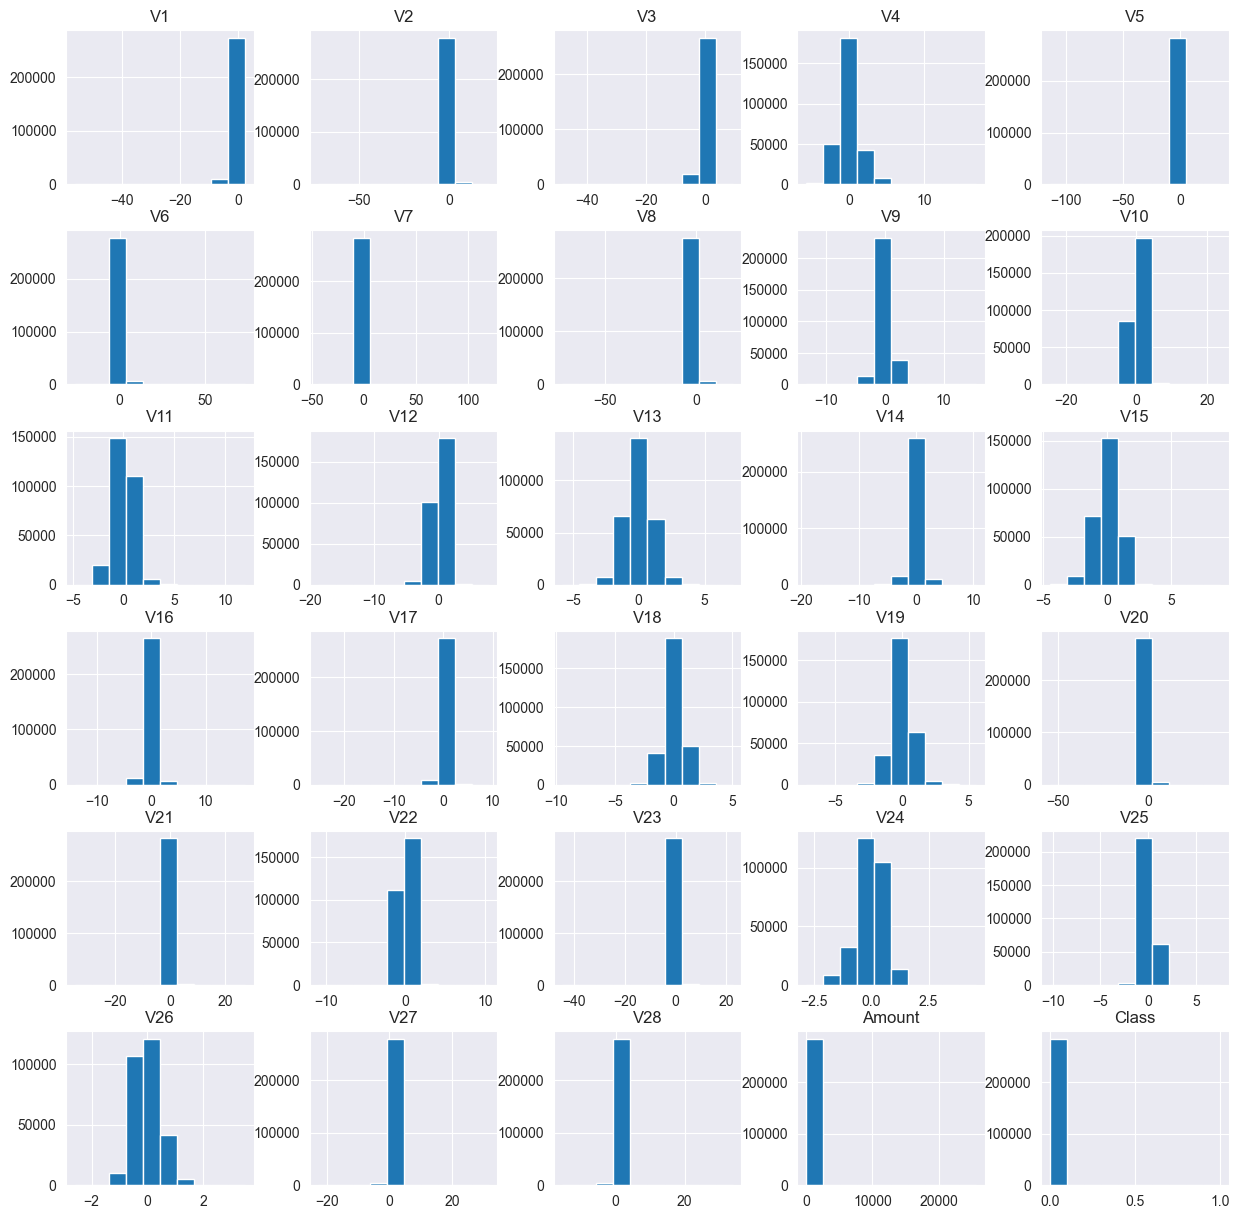

In [9]:
df.hist(figsize=(15,15));

<Figure size 2000x1000 with 0 Axes>

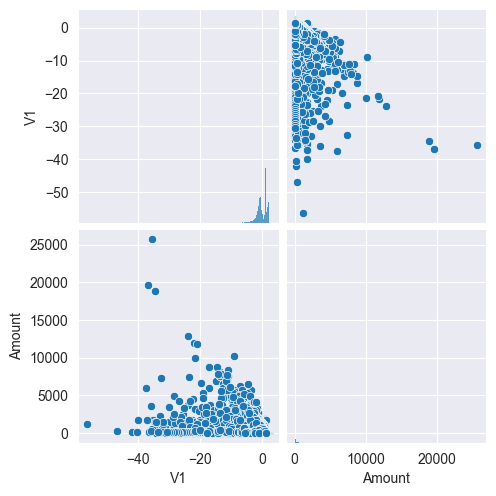

In [10]:
plt.figure(figsize=(20,10))
sns.pairplot(df[["Time","V1", "Amount"]])

In [11]:
plt.figure(figsize=(20,5))
sns.scatterplot(df["Time"], df["V1"], hue=df["Class"])

TypeError: scatterplot() takes from 0 to 1 positional arguments but 2 positional arguments (and 1 keyword-only argument) were given

<Figure size 2000x500 with 0 Axes>

In [ ]:
plt.figure(figsize=(20,5))
sns.scatterplot(df["V1"], df["V2"], hue=df["Class"])

### 4. Preprocessing:

In [ ]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

X = df.iloc[:, :-1]
y = df.Class.values.ravel()

X_scaled = scaler.fit_transform(X)

###  5. Split Training and Testing Data:

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state=42)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)


### 6. Model Development

#### Random Forests Classification:

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

rfc = RandomForestClassifier()
rfc.fit(X_train, y_train)
y_pred = rfc.predict(X_test)

print(classification_report(y_test, y_pred))

#### XGBoost Classification:

In [ ]:
from xgboost import XGBClassifier

xgb = XGBClassifier()
xgb.fit(X_train, y_train)
y_pred = xgb.predict(X_test)

print(classification_report(y_test, y_pred))

#### Artificial Neural Network using Keras:

In [ ]:
from tensorflow import keras
print(keras.__version__)

In [ ]:
model = keras.Sequential(
    [
        keras.layers.Dense(32, activation="relu", input_shape=(X_train.shape[-1],)),
        keras.layers.Dense(128, activation="relu"),
        keras.layers.Dropout(0.3),
        keras.layers.Dense(256, activation="relu"),
        keras.layers.Dropout(0.3),
        keras.layers.Dense(1, activation="sigmoid"),
    ]
)
model.summary()

In [ ]:
model.compile(
    optimizer=keras.optimizers.Adam(1e-2), 
    loss="binary_crossentropy", 
    metrics=["accuracy"]
)

In [ ]:
history = model.fit(
                    X_train,
                    y_train,
                    batch_size=2048,
                    epochs=30,
                    verbose=2,
                    validation_split = 0.2)

In [ ]:
history.history.keys()

In [ ]:
results = pd.DataFrame(history.history)
results.head(5)

In [ ]:
plt.figure(figsize = (15,4))

plt.subplot(121)
plt.plot(results.index, results.accuracy, label="Training Accuracy", linewidth=4)
plt.plot(results.index, results.val_accuracy, label="Validation Accuracy", linewidth=4)
plt.xlabel("Epochs", fontsize=15)
plt.ylabel("Accuracy Score", fontsize=15)
plt.title("Training and Validation Accuracy over Epochs" , fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

plt.subplot(122)
plt.plot(results.index, results.loss, label="Training Loss", linewidth=4)
plt.plot(results.index, results.val_loss, label="Validation Loss", linewidth=4)
plt.xlabel("Epochs", fontsize=15)
plt.ylabel("Accuracy Score", fontsize=15)
plt.title("Training and Validation Loss over Epochs", fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

#### Artificial Neural Network using Keras with Metrics & Weights:

In [ ]:
counts = np.bincount(y_train)
wt_0 = 1.0 / counts[0]
wt_1 = 1.0 / counts[1]

print(wt_0)
print(wt_1)

In [ ]:
model_2 = keras.Sequential(
    [
        keras.layers.Dense(
            256, activation="relu", input_shape=(X_train.shape[-1],)
        ),
        keras.layers.Dense(256, activation="relu"),
        keras.layers.Dropout(0.3),
        keras.layers.Dense(256, activation="relu"),
        keras.layers.Dropout(0.3),
        keras.layers.Dense(1, activation="sigmoid"),
    ]
)
model_2.summary()

In [ ]:
metrics = [
    keras.metrics.Precision(name="precision"),
#     keras.metrics.Recall(name="recall"),
#     keras.metrics.Accuracy(name="accuracy")
]

model_2.compile(
    optimizer=keras.optimizers.Adam(1e-2), loss="binary_crossentropy", metrics=metrics
)



history = model_2.fit(
                    X_train,
                    y_train,
                    batch_size=2048,
                    epochs=30,
                    verbose=2,
                    validation_split = 0.2,
                    class_weight = {0: wt_0, 1: wt_1}
)

In [ ]:
score = model_2.evaluate(X_test, y_test)


#### Convolutional Neural Network using Keras with Metrics & Weights:

In [ ]:
import keras
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, Dense, Flatten, Dropout, BatchNormalization
from keras.optimizers import Adam
from keras.callbacks import TensorBoard

In [ ]:
X_train.shape[-1]

In [ ]:
X_test_d = np.expand_dims(X_test, -1)
X_train_d  = np.expand_dims(X_train, -1)

In [ ]:
X_test_d

In [ ]:
model_3 = Sequential()
model_3.add(Conv1D(32, 2, activation='relu', input_shape=X_test_d[0].shape))
model_3.add(BatchNormalization())
model_3.add(Dropout(0.1))

model_3.add(Conv1D(64, 2, activation='relu'))
model_3.add(BatchNormalization())
model_3.add(Dropout(0.2))

model_3.add(Conv1D(128, 2, activation='relu'))
model_3.add(BatchNormalization())
model_3.add(Dropout(0.3))

model_3.add(Flatten())
model_3.add(Dropout(0.4))
model_3.add(Dense(512, activation='relu'))
model_3.add(Dropout(0.5))

model_3.add(Dense(1, activation='sigmoid'))

In [ ]:
model_3.summary()

In [ ]:
METRICS = [
    'accuracy',
    keras.metrics.Precision(name='precision'),
    keras.metrics.Recall(name='recall')
]

model_3.compile(optimizer='adam', loss='binary_crossentropy', metrics=METRICS)
history = model_3.fit(X_train_d, y_train, 
              validation_split=0.2,
              batch_size=16, 
              epochs=20, 
             )

In [ ]:
score = model.evaluate(X_test, y_test)
score

In [ ]:
plt.figure(figsize=(12, 16))

plt.subplot(4, 2, 1)
plt.plot(history.history['loss'], label='Train Loss', linewidth=4)
plt.plot(history.history['val_loss'], label='Val Loss', linewidth=4)
plt.legend()
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.axvline(x=18, color="red",linestyle='dashed', linewidth=1)


plt.subplot(4, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy', linewidth=4)
plt.plot(history.history['val_accuracy'], label='Val Accuracy', linewidth=4)
plt.legend()
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.axvline(x=18, color="red",linestyle='dashed', linewidth=1)


plt.subplot(4, 2, 3)
plt.plot(history.history['precision'], label='Train Precision', linewidth=4)
plt.plot(history.history['val_precision'], label='Val Precision', linewidth=4)
plt.legend()
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.axvline(x=17.5, color="red",linestyle='dashed', linewidth=1)

plt.subplot(4, 2, 4)
plt.plot(history.history['recall'], label='Train Recall', linewidth=4)
plt.plot(history.history['val_recall'], label='Val Recall', linewidth=4)
plt.legend()
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.axvline(x=17.5, color="red",linestyle='dashed', linewidth=1)
